In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load in CSV file for ML model to train and test with
data = pd.read_csv('../../Cleaned/14-18_ML_test.csv')
# Drop null or NA values from df
data = data.dropna()

In [3]:
# Drop the index and Time Group Columns as we do not need them for the model
data = data.drop(columns=['Unnamed: 0','Time Group'])
# Disply all column names to ensure accuracy. These will be 'X' values in Model
list(data.columns)

['Age',
 'Previous Accident',
 'Previous DWI',
 'Previous Speeding',
 'INJ_SEV',
 'Helmet Use',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'Sunday',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Male',
 'Female',
 'Gender Neutral',
 'No Drugs',
 'Drug Use Reported',
 'No Drinking',
 'Drinking Reported',
 'Clear Weather',
 'Rainy Weather',
 'Foggy Weather',
 'Severly Windy Weather',
 'Blowing Sand Weather',
 'Other Weather',
 'Cloudy Weather']

In [5]:
# Feeding data into our model
X = data.drop(["INJ_SEV","Other Weather","Cloudy Weather"], axis=1)
y = data["INJ_SEV"]
# Print shape of model data
print(X.shape, y.shape)

(3839, 36) (3839,)


In [6]:
# Import TTS for training model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [7]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

#giving weight to each outcome to train model
weights = {0:2,1:0.8,2:0.2}

# Creating Classifier with estimators and weights
grid = RandomForestClassifier(n_estimators=1000, class_weight=weights)

# Training the model
grid.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 2, 1: 0.8, 2: 0.2},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [134]:
# param_grid = {"n_estimators" : [50, 100, 200,250],
#              "max_depth" : [None, 6, 8, 10],
#              "max_leaf_nodes": [None, 5, 10, 20]}
# from sklearn.model_selection import GridSearchCV
# grid = GridSearchCV(grid, param_grid=param_grid, cv=5, verbose=2)
# # grid.fit(X_train,y_train)

In [8]:
# Print Training and Test data
print(f"Training Data Score: {grid.score(X_train, y_train)}")
print(f"Testing Data Score: {grid.score(X_test, y_test)}")

Training Data Score: 0.9947898575894408
Testing Data Score: 0.8302083333333333


In [9]:
# Prit out dredictions vs reality
predictions = grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}") 

First 10 Predictions:   [2 2 2 2 2 0 0 2 0 2]
First 10 Actual labels: [2, 0, 2, 2, 2, 0, 1, 2, 0, 2]


In [10]:
# Visualize probability of each outcome
probs = grid.predict_proba(X_test)
pred_df = pd.DataFrame({
    "Prediction": predictions, 
    "Actual": y_test, 
    "P(No Injury)": [p[0] for p in probs], 
    "P(Injury)": [p[1] for p in probs],
    "P(Fatility)": [p[2] for p in probs]
    }).reset_index(drop=True)

pred_df.head(10)

,Prediction,Actual,P(No Injury),P(Injury),P(Fatility)
0,2,2,0.272,0.081,0.647
1,2,0,0.422,0.153,0.425
2,2,2,0.018,0.057,0.925
3,2,2,0.033,0.285,0.682
4,2,2,0.000,0.013,0.987
5,0,0,0.980,0.007,0.013
6,0,1,0.704,0.291,0.005
7,2,2,0.002,0.047,0.951
8,0,0,0.938,0.008,0.054
9,2,2,0.019,0.180,0.801


In [11]:
# Imported so that confusion matrix can be plotted. Import code from SKLearn is broken
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[234  29  12]
 [ 49  41  42]
 [ 15  16 522]]


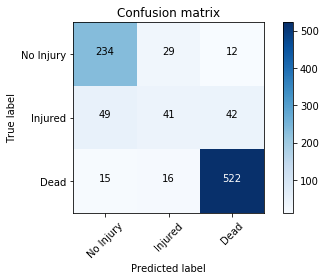

In [13]:
# Create confusion matrix and matricies for [0] - No Injury; [1] - Injured
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions)

plot_confusion_matrix(cm, cmap=plt.cm.Blues, classes=['No Injury','Injured','Dead'])

In [14]:
# Plot out feature importance descending
pd.DataFrame({'Feature':X_train.columns, 'Importance':grid.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
4,Helmet Use,0.351506
0,Age,0.224650
3,Previous Speeding,0.048847
1,Previous Accident,0.032200
31,Clear Weather,0.024870
23,Saturday,0.020057
17,Sunday,0.016351
10,June,0.015766
22,Friday,0.014817
14,October,0.013654


In [15]:
import pickle

with open('../../model/model.pkl','wb') as f:
    pickle.dump(grid, f)

In [16]:
with open('../../model/model.pkl', 'rb') as f:
    model = pickle.load(f)

In [17]:
print(f"Test set score: {model.score(X_test, y_test)}")

Test set score: 0.8302083333333333


In [18]:
model

RandomForestClassifier(bootstrap=True, class_weight={0: 2, 1: 0.8, 2: 0.2},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)